# Inverse design of inflated membranes through Machine Learning


## Import packages and library

In [27]:
from __future__ import division, print_function, absolute_import
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA as RandomizedPCA
import tensorflow as tf
import pandas as pd
import random
from numpy import genfromtxt
from datetime import datetime
#for plotting
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
sns.set_context("paper", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
tf.__version__

'1.12.0'

## Dataset
Each dataset class contains 60000 simulations.
Each simulation shows the behavior of a different configuration of the membrane.

The membrane is represented as a binary grid 10x10 (100 pixels)
The displacements are represented by voxels 


## Use all datasets 

In [29]:
comb='all'
numpyData_exists=True

if not numpyData_exists:
    data1 = pd.read_csv('FE_Etch_60000_Voxels_HR.csv', delimiter=',', header=None)
    data2 = pd.read_csv('FE_Random_60000_Voxels_HR.csv', delimiter=',', header=None)
    data3 = pd.read_csv('FE_Struc_60000_Voxels_HR.csv', delimiter=',',header=None)
    
    data = np.concatenate((data1, data2), axis=0)
    data = np.concatenate((data, data3), axis=0)
    YDIM= len(data[0])-101
    np.random.shuffle(data)
    np.save('dataAll_shuffledDATE.npy', data)
    
    
else:
    data = np.load('../dataAll_shuffledNov20.npy')
    YDIM= len(data[0])-101
    data = data.astype(float)
    #shift pressure to real value 
    data[:, 0] = data[:, 0] + 0.5 
    
#We are randomly splitting the Dataset into:
# 80% Training Set (2000 simulations)
# 10% Test Set
# 10% Validation Set
#data =data1
ntotal = len(data)
#np.random.shuffle(data) no need to shuffle 
Xdata = data[:, :101] #binary 
Ydata = data[:, 101:] #voxels
ftrain = int(0.8*ntotal) 
fvalid = int(0.10*ntotal)+ftrain
ftest = int(0.10*ntotal)+fvalid

#membrane design = Input Data
X_train = Xdata[0:ftrain]
X_valid = Xdata[ftrain:fvalid]
X_test = Xdata[fvalid:ftest]

#x,y,z displacements = Output Data
y_train = Ydata[0:ftrain]
y_valid = Ydata[ftrain:fvalid]
y_test = Ydata[fvalid:ftest]


y_train_all = y_train 
y_valid_all = y_valid
y_test_all = y_test

h=10
w=10
ydim=YDIM
    

## Use this for training with different combinations of training classes 

In [4]:
#first load shuffled datasets, if doesn't exsist create ones 
numpyData_exists=True

if not numpyData_exists:
    data_etch = pd.read_csv('FE_Etch_60000_Voxels_HR.csv', delimiter=',', header=None)  #islands 
    data_random = pd.read_csv('FE_Random_60000_Voxels_HR.csv', delimiter=',', header=None) #randoms 
    data_struct = pd.read_csv('FE_Struc_60000_Voxels_HR.csv', delimiter=',',header=None) #fibers 
    
    data_etch=np.array(data_etch)
    np.random.shuffle(data_etch)
    np.save('data_etch_shuffledApril7.npy', data_etch)
    
    data_random = np.array(data_random)
    np.random.shuffle(data_random)
    np.save('data_random_shuffledApril7.npy', data_random)
    
    data_struct=np.array(data_struct)
    np.random.shuffle(data_struct)
    np.save('data_struct_shuffledApril7.npy', data_struct)      
else:
    data_R = np.load('data_random_shuffledApril7.npy') #random
    data_F = np.load('data_struct_shuffledApril7.npy')  #fibers/struct
    data_I = np.load('data_etch_shuffledApril7.npy') #island/etch 
    YDIM= len(data_R[0])-101
    
    #make sure they are in float 
    data_R = data_R.astype(float)
    data_F = data_F.astype(float)
    data_I = data_I.astype(float)
    
    #shift pressure to 1.5, 2.5, 3.5 
    data_R[:, 0] = data_R[:, 0]+0.5
    data_F[:, 0] = data_F[:, 0]+0.5
    data_I[:, 0] = data_I[:, 0]+0.5
    
#We split the pre-shuffled Dataset into:
# 80% Training Set (2000 simulations)
# 10% Test Set
# 10% Validation Set
#data =data1
ntotal = len(data_R)
ftrain = int(0.8*ntotal) 
fvalid = int(0.1*ntotal)+ftrain
ftest = int(0.1*ntotal)+fvalid


#np.random.shuffle(data) no need to shuffle 
Xdata_R = data_R[:, :101] #binary 
Ydata_R = data_R[:, 101:] #voxels

Xdata_I = data_I[:, :101] #binary 
Ydata_I = data_I[:, 101:] #voxels

Xdata_F = data_F[:, :101] #binary 
Ydata_F = data_F[:, 101:] #voxels

#membrane design = Input Data
X_valid = np.concatenate((Xdata_R[ftrain:fvalid], Xdata_I[ftrain:fvalid]), axis=0)
X_valid = np.concatenate ((X_valid, Xdata_F[ftrain:fvalid]), axis=0)

X_test = np.concatenate((Xdata_R[fvalid:ftest], Xdata_I[fvalid:ftest]), axis=0)
X_test = np.concatenate ((X_test, Xdata_F[fvalid:ftest]), axis=0)

y_valid = np.concatenate((Ydata_R[ftrain:fvalid], Ydata_I[ftrain:fvalid]), axis=0)
y_valid = np.concatenate ((y_valid, Ydata_F[ftrain:fvalid]), axis=0)

y_test = np.concatenate((Ydata_R[fvalid:ftest], Ydata_I[fvalid:ftest]), axis=0)
y_test = np.concatenate((y_test, Ydata_F[fvalid:ftest]), axis=0)


np.random.seed(42) 
comb='RIFr'
#full ftrain
if comb=='R':
    X_train = Xdata_R[:ftrain]
    y_train = Ydata_R[:ftrain]    
if comb=='I':
    X_train = Xdata_I[:ftrain]
    y_train = Ydata_I[:ftrain]
if comb=='F':
    X_train = Xdata_F[:ftrain]
    y_train = Ydata_F[:ftrain]
    
    
if comb=='RI':
    X_train = np.concatenate((Xdata_R[:ftrain//2], Xdata_I[:ftrain//2]), axis=0)
    y_train = np.concatenate((Ydata_R[:ftrain//2], Ydata_I[:ftrain/2]), axis=0)
if comb=='RIr':
    dataAll = np.concatenate((data_R[:ftrain//2], data_I[:ftrain//2]), axis=0)
    np.random.shuffle(dataAll)
    
    X_train = dataAll[:, :101] #binary 
    y_train = dataAll[:, 101:]
                             
if comb=='RF':
    X_train = np.concatenate((Xdata_R[:ftrain//2], Xdata_F[:ftrain//2]), axis=0)
    y_train = np.concatenate((Ydata_R[:ftrain//2], Ydata_F[:ftrain//2]), axis=0)
    
    
if comb=='RFr':
    dataAll = np.concatenate((data_R[:ftrain//2], data_F[:ftrain//2]), axis=0)
    np.random.shuffle(dataAll)
    
    X_train = dataAll[:, :101] #binary 
    y_train = dataAll[:, 101:]
    
    
#########
                             
if comb=='IF':
    X_train = np.concatenate((Xdata_I[:ftrain//2], Xdata_F[:ftrain//2]), axis=0)
    y_train = np.concatenate((Ydata_I[:ftrain//2], Ydata_F[:ftrain//2]), axis=0)  
    
if comb=='IFr':
    dataAll = np.concatenate((data_I[:ftrain//2], data_F[:ftrain//2]), axis=0)
    np.random.shuffle(dataAll)
    
    X_train = dataAll[:, :101] #binary 
    y_train = dataAll[:, 101:] 
    
    
#########
    
if comb=='RIF':
    X_train = np.concatenate((Xdata_R[:ftrain//3], Xdata_I[:ftrain//3]), axis=0)
    X_train = np.concatenate((X_train, Xdata_F[:ftrain//3]), axis=0)
    
    y_train = np.concatenate((Ydata_R[:ftrain//3], Ydata_I[:ftrain//3]), axis=0)  
    y_train = np.concatenate((y_train, Ydata_F[:ftrain//3]), axis=0)
    
    
if comb=='RIFr':
    dataAll = np.concatenate((data_R[:ftrain//3], data_I[:ftrain//3]), axis=0)
    dataAll = np.concatenate((dataAll, data_F[:ftrain//3]), axis=0)
    np.random.shuffle(dataAll)
    
    X_train = dataAll[:, :101] #binary 
    y_train = dataAll[:, 101:] #voxels

ydim=YDIM
h=10
w=10
y_train_all = y_train 
y_valid_all = y_valid
y_test_all = y_test
#X_train.shape, X_valid.shape, X_test.shape, y_train.shape, y_valid.shape, y_test.shape

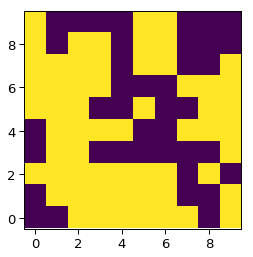

In [30]:
plt.imshow(X_train[3000, 1:].reshape(10, 10), origin='below')

### Input data shape and initialization - helper function

In [31]:
img_size1 = 10
img_size2 = 10

# Images are stored in one-dimensional arrays of this length.
img_size_flat = img_size1 * img_size2

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size1, img_size2)

# Number of colour channels for the images: 1 channel for gray-scale.
num_channels = 1



# A custom initialization (see Xavier Glorot init)
seednumber=3215
#3215 was used for lambda10, fcl50, and all 
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1.5/ tf.sqrt(shape[0] / 2.), seed=seednumber)   #1.5 for standard

tf.set_random_seed(seednumber)

## Model parameters

In [32]:
# FCL Network Parameters
image_dim = 100 #10x10 pixels
hidden_dim1 = 1000
hidden_dim2 = 1000
y_dim = YDIM #changed
learning_rate = 0.0001
batch_size = 100
dropout_rate = 0
weights = {}
biases = {}
weightsx={}
biasesx={}
input_dim = image_dim + 1
output_dim = input_dim

In [33]:
weightsx = {
    'net_h1': tf.Variable(glorot_init([y_dim, hidden_dim1])),
    'net_h2': tf.Variable(glorot_init([hidden_dim1, hidden_dim2])),
    'net_out': tf.Variable(glorot_init([hidden_dim2, output_dim]))
}
biasesx = {
    'net_b1': tf.Variable(glorot_init([hidden_dim1])),
    'net_b2': tf.Variable(glorot_init([hidden_dim2])),
    'net_out': tf.Variable(glorot_init([output_dim]))
}

In [34]:
input_image = tf.placeholder(tf.float32, shape=[None, input_dim]) #binary design + pressure
y_true = tf.placeholder(tf.float32, shape=[None, y_dim]) #voxels 

### Inverse design network

In [35]:
z= y_true
invNet = tf.matmul(z, weightsx['net_h1']) + biasesx['net_b1']
invNet = tf.nn.relu(invNet)
invNet = tf.matmul(invNet, weightsx['net_h2']) + biasesx['net_b2']
invNet = tf.nn.relu(invNet)
invNet = tf.matmul(invNet, weightsx['net_out']) + biasesx['net_out']

### Loss Function

In [36]:
lambda0=50
def total_loss(x_predict, x_true):
    binary_loss = tf.reduce_sum(tf.pow(tf.sigmoid(x_predict[:,1: ]) - x_true[:, 1:], 2)) #binary designs
    pressure_loss =  tf.reduce_sum(tf.pow(x_predict[:,0] - x_true[:,0], 2)) #pressure 
     
    return binary_loss + pressure_loss
loss = total_loss(invNet, input_image)
loss_op = tf.reduce_mean(loss)

### Adam Optimizer and Loss Minimization

In [37]:
#optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) #epsilon=.001
#.minimize(loss)
train_op = optimizer.minimize(loss_op)
init = tf.global_variables_initializer()
sess = tf.Session()
# Run the initializer
sess.run(init)

### Training Epochs, Batches, Steps

In [38]:
n_total = len(X_train)
total_batches = int(n_total/batch_size)
epochs =50
num_steps = epochs * total_batches
print(num_steps)

72000


In [39]:
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)
# Training
print(comb, lambda0, hidden_dim1)
for i in range(0, num_steps):
    # Prepare Data
    # Get the next batch of data
    #for j in range(total_batches-1):
    #    batch_x =X_train[int(j*batch_size):int((j+1)*batch_size)]
    j = (i % total_batches) +1
    batch_x = X_train[batch_size*(j-1):batch_size*j] 
    batch_y = y_train_all[batch_size*(j-1):batch_size*j, :y_dim] 
    #batch_y = y_train[batch_size*(j-1):batch_size*j] 
    # Train
    feed_dict = {input_image: batch_x, y_true: batch_y}
    _, l, l1 = sess.run([train_op, loss_op, loss], feed_dict=feed_dict)
    #_, l= sess.run([train_op, loss_op], feed_dict=feed_dict)
    if i % 1000 == 0:
        #print('Step %i, Loss: %f ' % (i, l))
        print('Step %i, Loss: %f %f' % (i, l, l1))

now = datetime.now()

current_time = now.strftime("%H:%M:%S")
print("Current Time =", current_time)

Current Time = 21:54:42
all 50 1000
Step 0, Loss: 3400.905029 3400.905029
Step 1000, Loss: 718.903442 718.903442
Step 2000, Loss: 488.981873 488.981873
Step 3000, Loss: 354.929535 354.929535
Step 4000, Loss: 327.138275 327.138275
Step 5000, Loss: 300.164825 300.164825
Step 6000, Loss: 316.960480 316.960480
Step 7000, Loss: 305.595764 305.595764
Step 8000, Loss: 267.245941 267.245941
Step 9000, Loss: 236.347153 236.347153
Step 10000, Loss: 185.060501 185.060501
Step 11000, Loss: 224.928284 224.928284
Step 12000, Loss: 203.497940 203.497940
Step 13000, Loss: 224.671021 224.671021
Step 14000, Loss: 172.669830 172.669830
Step 15000, Loss: 203.608582 203.608582
Step 16000, Loss: 188.602448 188.602448
Step 17000, Loss: 188.738327 188.738327
Step 18000, Loss: 175.641235 175.641235
Step 19000, Loss: 168.518723 168.518723
Step 20000, Loss: 172.541107 172.541107
Step 21000, Loss: 155.327606 155.327606
Step 22000, Loss: 105.930260 105.930260
Step 23000, Loss: 157.453552 157.453552
Step 24000, Los

## Eavaluate accuracies 

In [40]:
#NOTE execute the accuracy functions below 
if comb=='all':
    print('FCL'+str(hidden_dim1)+'FCL'+str(hidden_dim2)+'ep'+str(epochs)+'lambda'+str(lambda0))

    setTrain='train'
    print(setTrain)
    listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, 0, 3, 3, 0, 1, 1)


    setTrain='valid'
    print(setTrain)
    listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, 0, 3, 3, 0, 1, 1)


    setTrain='test'
    print(setTrain)
    listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, 0, 3, 3, 0, 1, 1)
    
    
else:

    print(str(comb)+' FCL'+str(hidden_dim1)+'FCL'+str(hidden_dim2)+'ep'+str(epochs)+'lambda'+str(lambda0))
    fractions=[1, 2, 3]
    #train
    setTrain='train'
    print(setTrain)
    listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, 0, 3, 3, 0, 1, 1)

    #test
    setTrain='test'
    print(setTrain)
    for ff in fractions:
        listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, ff-1, ff, 3, 0, 1, 1)

    listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, 0, 3, 3, 0, 1, 1)

    setTrain='valid'
    print(setTrain)
    for ff in fractions:
        listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, ff-1, ff, 3, 0, 1, 1)

    listR2_binary, listR2_pressure = calculateAccuracy2(setTrain, 0, 3, 3, 0, 1, 1)


FCL1000FCL1000ep50lambda50
train
0.987415763889215 0.9310158943380199
valid
0.9728805555554962 0.8765192985077328
test
0.9728222222221627 0.8732069617534916


## Use user specified designs for inverse design 

In [67]:
#dataformat for inverse designs input voxels 
#truth binary1, voxels1 w pressure 1
#truth binary1, voxels1 w pressure 2
#truth binary1, voxels1 w pressure 3
#truth binary2, voxels w pressure 1
#....
#....

#allDesigns='all'
designs='new'

if designs=='all':
    #voxels_design = genfromtxt('../inverseDesign_Nov23/inverseAnimals_fromUsers.csv', delimiter=',')
    #p_from_design = [1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 
    #                 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5]
    #voxels_design = genfromtxt('../inverseDesign_Nov23/inverse_scarsNEW_fromUsers.csv', delimiter=',')
    #p_from_design = [1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5]
    #znew = voxels_design[:, 100:]
    
    voxels_design = genfromtxt('../inverseDesign_June20/inverse_from_stl.csv', delimiter=',')
    p_from_design = [1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]
    znew=voxels_design
    

    p_from_design = np.array(p_from_design)
    p_from_design = p_from_design.reshape((len(p_from_design), 1))
    x_from_design = np.concatenate((p_from_design, voxels_design), axis=1)
    
    
    
    
#znew = znew.reshape((1,YDIM))
    #znew.shape
elif designs=='one':
    voxels_design = genfromtxt('dog11_HR_voxel.csv', delimiter=',')
    znew = voxels_design[2, 100:]
    znew = znew.reshape((1, YDIM))
elif designs=='new':
    #test_case1 = pd.read_csv('../inverseDesign_validated_by_FEM/FE_case_1_HR_voxel.csv', delimiter=',', header=None)
    test_case1 = pd.read_csv('../inverseDesign_June20/C_NEW_HR_voxel.csv', delimiter=',', header=None)
    
    test_case1 = np.array (test_case1)
    p = np.ones((3, 1))
    #print(p.shape, test_case1.shape)
    p[0]=1.5
    p[1]=2.5
    p[2]=3.5
    #p = p.reshape ((3, 1))
    test_case1 = np.concatenate ((p, test_case1), axis=1)
    test_case1.shape
    x_from_design = test_case1
    voxels_design = test_case1[:, 1:101]
    znew = test_case1[:, 101:]
    znew = znew.reshape(len(znew), YDIM)




## Use the trained model to perform inverse design (prediction)

In [69]:
dcheck=False
z_input = tf.placeholder(tf.float32, shape=[None, latent_dim+y_dim])

invNet2 = tf.matmul(z_input, weightsx['decoder_h1']) + biasesx['decoder_b1']
invNet2 = tf.nn.relu(invNet2)
invNet2 = tf.matmul(invNet2, weightsx['decoder_h2']) + biasesx['decoder_b2']
invNet2 = tf.nn.relu(invNet2)
invNet2 = tf.matmul(invNet2, weightsx['decoder_out']) + biasesx['decoder_out']
#decoder2 = tf.nn.sigmoid(invNet2)
#decoder2 = tf.round(invNet2) #REMEMBER already use ROUND function 

x_mean = sess.run(invNet2, feed_dict = {z_input:znew})

#use the test set (subset of the original data not user specified designs) to check prediction quality
if dcheck:
    x_sample =X_test
    y_sample =y_test_all[:, :y_dim]
    x_mean = sess.run(invNet2, feed_dict = {z_input:y_sample})
    listBinary, listMSEpressure = doublecheckAccuracy (x_mean, x_sample)
    #PZH, June 20: all good for this code


## Check results 

2.2071686


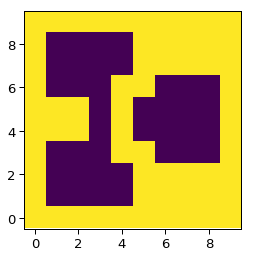

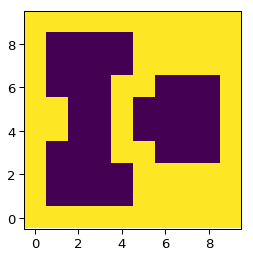

2.8032496


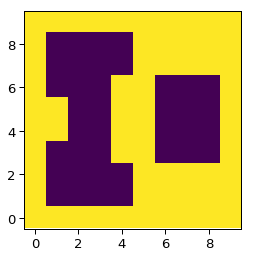

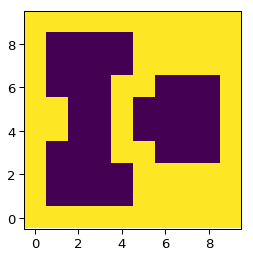

3.8018396


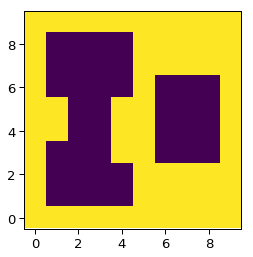

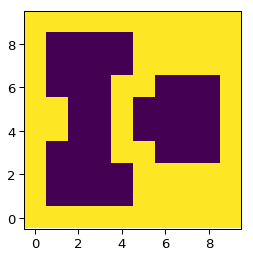

In [79]:
h=10
w=10
for i in range(len(x_mean)):
    #i=22
    plt.imshow(np.round(1/(1+np.exp(-x_mean[i, 1:101]))).reshape(10, 10), origin='below')
    print (x_mean[i, 0])
    plt.show()
    #plt.colorbar()
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()
    
    plt.imshow(x_from_design[i, 1:101].reshape(10, 10), origin='below')
    plt.show()

(24, 101)

In [77]:
listBinary, listRMSEpressure = doublecheckAccuracy(x_mean, x_from_design)
listBinary = np.array(listBinary)
listRMSEpressure = np.array(listRMSEpressure) 
listBinary=listBinary.reshape((len(listBinary), 1))
listRMSEpressure=listRMSEpressure.reshape((len(listRMSEpressure), 1))
listBinary.shape, listRMSEpressure.shape
ac = np.concatenate ((listBinary, listRMSEpressure), axis=1)

0.9766666666666666 0.6584225720911832


In [76]:
ac

array([[0.98      , 0.5000874 ],
       [0.98      , 0.09196032],
       [0.97      , 0.09110714]])

In [78]:
textmodel="_f"+str(hidden_dim3)+"f"+str(hidden_dim4)+"lambda"+str(lambda0)+"_June20"
#shapes = "inverseAnimals"
#shapes = "inverseScarsNEW"
#shapes = "inverseSTL"
shapes = "inverseC_NEW"
np.savetxt(shapes+"_accuracy_from_INet"+textmodel+".csv", ac, delimiter=',')
np.savetxt(shapes+"_BINARYDESIGN_from_INet"+textmodel+".csv", np.round(1/(1+np.exp(-x_mean[:, 1:101]))), delimiter=",")
np.savetxt(shapes+"_PRESSURE_from_INet"+textmodel+".csv", x_mean[:, 0], delimiter=",")

## Accuracy metric 

In [24]:
from sklearn.metrics import r2_score, accuracy_score

def weighted_score (true, predict):
    count = 0 
    score = 0
    for i in range (len(true)):
        #only evaluate the surface and underneath it i.e when voxel==1 (non empty)
        if true[i]==1:
            count += 1 
            if true[i]==predict[i]:
                score +=1 
    if count==0:
        return accuracy_score(true, predict)
    else:
        return score/count
            

def calculateAccuracy2(check, f1, f2, fractest, f3, f4, fractrain):
    f1 = f1*len(y_test_all)//fractest
    f2 = f2*len(y_test_all)//fractest
    f3 = f3*len(y_train_all)//fractrain
    f4 = f4*len(y_train_all)//fractrain
    
    
    if check=='test':
        x_sample =X_test[f1:f2]
        y_sample =y_test_all[f1:f2, :y_dim]
    if check=='valid':
        x_sample =X_valid[f1:f2]
        y_sample =y_valid_all[f1:f2, :y_dim]
    if check=='train':
        x_sample =X_train[f3:f4]
        y_sample =y_train_all[f3:f4, :y_dim]
    if check=='special':
        x_sample = test_case1[:, 0:101]
        y_sample = test_case1[:, 101:]
    

    """Binary accuracy score and R2 on pressure"""
    #BINARY DESIGNS 
    #x_sample =X_train
    #y_sample =y_train_all[:, :y_dim]

    feed_dict = {input_image: x_sample, y_true: y_sample}
    x_mean = sess.run(invNet,feed_dict=feed_dict)
    
    ave_R2 = 0 
    mse = 0 
    listR2_binary = []
    listMSE = []

    for jj in range(len(y_sample)):
        
        r2s = accuracy_score(x_sample[jj, 1:], np.round(1/(1+np.exp(-x_mean[jj, 1:]))))
        ave_R2 = ave_R2+r2s
        temp  = np.sum((x_sample[jj, 1:]-np.round(1/(1+np.exp(-x_mean[jj, 1:]))))**2)
        mse = mse+temp
        listMSE.append(temp)
        listR2_binary.append(r2s)
    
    ac_binary = ave_R2/(len(y_sample))
    ave_R2 = 0 
    mse = 0 
    listR2_pressure = []
    listMSE = []
    for jj in range(len(x_sample)):
        #r2s = r2_score(x_sample[jj, 0], x_mean[jj, 0])
        #ave_R2 = ave_R2+r2s
        temp  = np.sum((x_sample[jj, 0]-x_mean[jj, 0])**2)
        mse = mse+temp
        #listMSE.append(temp)
        listR2_pressure.append(mse)
    #print(r2s, temp)
    
    #PRSSURE  
    ave_R2 = 0 
    mse = 0 
    #ac_press=0
    #listR2_pressure = []
    #listMSE = []
    for jj in range(0, 1):
        r2s = r2_score(x_sample[:, jj], x_mean[:, jj])
        ave_R2 = ave_R2+r2s
        #temp  = np.sum((x_sample[:, jj]-x_mean[:, jj])**2)
        #mse = mse+temp
        #listMSE.append(temp)
        #listR2_pressure.append(r2s)
    
    

    ac_press = ave_R2
    
    print(ac_binary, ac_press)
    return listR2_binary, listR2_pressure 
#print ("R2 score :", ave_R2, mse/len(y_sample))
    



In [17]:
def savePredictions(filename, combinations, index):
    test_case1 = pd.read_csv(filename, delimiter=',', header=None)
    test_case1 = np.array (test_case1)
    p = np.ones((3, 1))
    #print(p.shape, test_case1.shape)
    p[0]=1.5
    p[1]=2.5
    p[2]=3.5
    #p = p.reshape ((3, 1))
    test_case1 = np.concatenate ((p, test_case1), axis=1)

    x_sample = test_case1[:, 0:101]
    y_sample = test_case1[:, 101:]
    

    #print (x_sample.shape, y_sample.shape)
    """Voxels accuracy"""
    
    
    feed_dict = {input_image: x_sample, y_true: y_sample}
    z_mu = sess.run(z,feed_dict=feed_dict)
    z_mu = np.round(z_mu)
    
    feed_dict = {input_image: x_sample, y_true: y_sample}
    x_mean = sess.run(decoder,feed_dict=feed_dict)
    #need to apply sigmoid to binaries 
    for jj in range(1, 101):
        x_mean[:, jj] =np.round(1/(1+np.exp(-x_mean[:, jj])))
    
    predictionMatrix = np.concatenate((x_mean, z_mu), axis=1 )
    plt.imshow((test_case1[index, 1:101].reshape([h, w])), origin='lower')
    plt.show()
    plt.imshow((predictionMatrix[index, 1:101].reshape([h, w])), origin='lower')
    plt.show()
    
    listR2_voxels, listR2_voxels_surface, listR2_binary, listR2_pressure = calculateAccuracy2(filename, 2, 3, 3, 0, 1, 1)
    
    listR2_voxels = np.array(listR2_voxels)
    listR2_voxels = listR2_voxels.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_voxels), axis=1)
    
    listR2_voxels_surface = np.array(listR2_voxels_surface)
    listR2_voxels_surface = listR2_voxels_surface.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_voxels_surface), axis=1)

    
    listR2_binary = np.array(listR2_binary)
    listR2_binary = listR2_binary.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_binary), axis=1)

    
    listR2_pressure = np.array(listR2_pressure)
    listR2_pressure = listR2_pressure.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_pressure), axis=1)
    

    
    np.savetxt("predictionsAndAccuracies-"+combinations+"-"+filename, predictionMatrix, delimiter=',')
    #np.savetxt("inverseAnimals_from_ML_f1000f500_Nov23.csv", np.round(1/(1+np.exp(-x_mean[:, 1:101]))), delimiter=",")
    #np.savetxt("inverseAnimals_from_ML_PRESSURE_f1000f500_Nov23.csv", x_mean[:, 0], delimiter=",")
    
    return predictionMatrix
#listR2_voxels, listR2_voxels_

In [22]:
def doublecheckAccuracy(x_predictions, x_true):
    x_sample = x_true
    x_mean = x_prediction
    
    ave_R2 = 0 
    mse = 0 
    listR2_binary = []
    listR2_pressure = []
    listMSE = []

    for jj in range(len(x_sample)):
        
        r2s = accuracy_score(x_sample[jj, 1:101], np.round(1/(1+np.exp(-x_mean[jj, 1:101]))))
        ave_R2 = ave_R2+r2s
        temp  = np.sum((x_sample[jj, 1:101]-np.round(1/(1+np.exp(-x_mean[jj, 1:101]))))**2)
        mse = mse+temp
        listMSE.append(temp)
        listR2_binary.append(r2s)
    #print(r2s, temp)
    ac_binary = ave_R2/(len(x_sample))
    
    #PRSSURE  
    
    mse = 0 
    list_MSEpressure = []
    listMSE = []
    for jj in range(len(x_sample)):
        #r2s = r2_score(x_sample[jj, 0], x_mean[jj, 0])
        #ave_R2 = ave_R2+r2s
        temp  = np.sum((x_sample[jj, 0]-x_mean[jj, 0])**2)
        mse = mse+np.sqrt(temp)
        #listMSE.append(temp)
        list_MSEpressure.append(temp)
   
    ave_R2 = 0 
    mse = 0 
    #listR2_pressure = []
    #listMSE = []
    for jj in range(0, 1):
        r2s = r2_score(x_sample[:, jj], x_mean[:, jj])
        ave_R2 = ave_R2+r2s
    
    
    ac_press = ave_R2
    
    print(ac_binary, ac_press)
    return listR2_binary, list_MSEpressure 

In [23]:
#get xyz coordinates to map voxels to real space 
from numpy import genfromtxt
xyz = genfromtxt('../voxel_points_HR.csv', delimiter=',')
#xyz = xyz.transpose(
h=10
w=10

In [24]:
#functions for plotting voxels
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

#3d plot 
def scatter3d(surface, color):


    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    ax.scatter(surface[:, 0], surface[:, 1], surface[:, 2], c=surface[:, 2], s=10, cmap=color)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    #ax.view_init(60, 35)
    ax.view_init(60, 150)

    plt.show()

#2d plot 
def scatter2d(surface, color):
    plt.scatter(surface[:, 0], surface[:, 1], c=surface[:,2],s =100, cmap=color)
    plt.xlim([-4, 15])
    plt.ylim([-4, 15])
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar()
    plt.show()

binary design


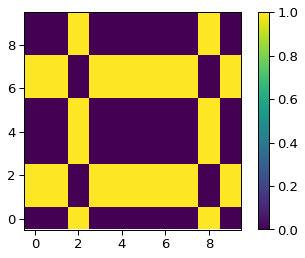

voxels


IndexError: index 28 is out of bounds for axis 0 with size 3

In [25]:
#z displacements
h=10
w=10
#for i in range (0, len(data2), 1000):
index  = 5
#10016
#8000
#10000
#L: 9296
#+: 9480 

print ("binary design")
#plt.imshow(np.rot90(data1[index, 1:101].reshape([h, w])))
plt.imshow((data_F[index, 1:101].reshape([h, w])), origin='lower')
#PZH: USE origin = 'lower' to plot from bottom to top

plt.colorbar()
plt.show()
#print ("z disp")
#plt.imshow(data_struct[index, 300:].reshape([h, w]), cmap='jet')
#plt.colorbar()
#plt.show()
#for j in range (0, len(data2), 10000):
print ("voxels")
#fig = plt.figure(figsize=(10,10))
k=101
point=[]    
for i in range(0, YDIM):
     if data_F[index][i+k]==1:
        point.append(xyz[i])

print (len(point))        
surface = np.array(point)
        #X = surface[:, 0]
        #Y = surface[:, 1]
        #Z = surface[:, 2]
scatter2d(surface, 'jet')
    
plt.show()

In [29]:
Ydata_F.shape

(60000, 9220)

In [34]:
xyz.shape

(3, 9220)

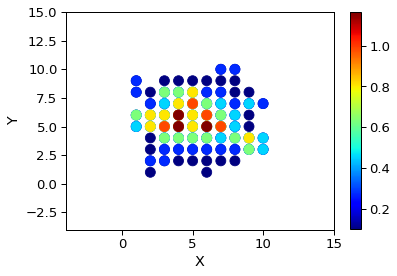

In [43]:
point = []
k=0
znew=Ydata_I
for j in range (1):
    for i in range(0, YDIM):
        if znew[j][i+k]==1:
            point.append(xyz[:, i])
    surface = np.array(point)
    #X = surface[:, 0]
    #Y = surface[:, 1]
    #Z = surface[:, 2]
    scatter2d(surface, 'jet')

In [32]:
znew[0].shape

(9220,)

In [133]:
#ac_wvoxel = ave_wscore/len(y_sample)
#print ("Weighted average:", ave_wscore/len(y_sample))



"""Binary accuracy score and R2 on pressure"""
#x_sample =X_train
#y_sample =y_train_all[:, :y_dim]

#feed_dict = {input_image: x_sample, y_true: y_sample}
#x_mean = sess.run(decoder,feed_dict=feed_dict)
    
ave_R2 = 0 
mse = 0 
listR2 = []
listMSE = []

for jj in range(1, 101):
        
    r2s = accuracy_score(x_sample[:, jj], np.round(1/(1+np.exp(-x_mean[:, jj]))))
    ave_R2 = ave_R2+r2s
    temp  = np.sum((x_sample[:, jj]-np.round(1/(1+np.exp(-x_mean[:, jj]))))**2)
    mse = mse+temp
    listMSE.append(temp)
    listR2.append(r2s)
    #print(r2s, temp)
        
        
#print ("Accuracy score on binary configurations:", ave_R2/100, mse/100/len(y_sample))
ac_binary = ave_R2/100

ave_R2 = 0 
mse = 0 
listR2 = []
listMSE = []
for jj in range(0, 1):
    r2s = r2_score(x_sample[:, jj], x_mean[:, jj])
    ave_R2 = ave_R2+r2s
    temp  = np.sum((x_sample[:, jj]-x_mean[:, jj])**2)
    mse = mse+temp
    listMSE.append(temp)
    listR2.append(r2s)
    #print(r2s)
    #print(r2s, temp)

ac_press = ave_R2
print (ac_binary, ac_press)
#return [ac_voxel, ac_wvoxel, ac_binary, ac_press]

0.9656127777777778 0.9289048627868879


In [171]:
#dataformat for inverse designs input voxels 
#truth binary1, voxels1 w pressure 1
#truth binary1, voxels1 w pressure 2
#truth binary1, voxels1 w pressure 3
#truth binary2, voxels w pressure 1
#....
#....

#allDesigns='all'
designs='all'

if designs=='all':
    voxels_design = genfromtxt('../inverseDesign_Nov23/inverseAnimals_fromUsers.csv', delimiter=',')
    #voxels_design = genfromtxt('inverse_scarsNew.csv', delimiter=',')


    znew = voxels_design[:, 100:]
    p_from_design = [1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 
                     1.5, 2.5, 3.5, 1.5, 2.5, 3.5, 1.5, 2.5, 3.5]
    p_from_design = np.array(p_from_design)
    p_from_design = p_from_design.reshape((len(p_from_design), 1))
    x_from_design = np.concatenate((p_from_design, voxels_design), axis=1)
    
#znew = znew.reshape((1,YDIM))
    #znew.shape
elif designs=='one':
    voxels_design = genfromtxt('dog11_HR_voxel.csv', delimiter=',')
    znew = voxels_design[2, 100:]
    znew = znew.reshape((1, YDIM))
elif designs=='new':
    test_case1 = pd.read_csv('inverseDesign_validated_by_FEM/FE_case_1_HR_voxel.csv', delimiter=',', header=None)
    
    test_case1 = np.array (test_case1)
    p = np.ones((3, 1))
    #print(p.shape, test_case1.shape)
    p[0]=1
    p[1]=2
    p[2]=3
    #p = p.reshape ((3, 1))
    test_case1 = np.concatenate ((p, test_case1), axis=1)
    test_case1.shape
    voxels_design = test_case1[:, 1:101]
    znew = test_case1[:, 101:]
    znew = znew.reshape(len(znew), YDIM)

In [30]:
z_input = tf.placeholder(tf.float32, shape=[None, latent_dim+y_dim])

decoder2 = tf.matmul(z_input, weightsx['decoder_h1']) + biasesx['decoder_b1']
decoder2 = tf.nn.relu(decoder2)
decoder2 = tf.matmul(decoder2, weightsx['decoder_h2']) + biasesx['decoder_b2']
decoder2 = tf.nn.relu(decoder2)
decoder2 = tf.matmul(decoder2, weightsx['decoder_out']) + biasesx['decoder_out']
#decoder2 = tf.nn.sigmoid(decoder2)
#decoder2 = tf.round(decoder2) #REMEMBER already use ROUND function 

x_mean = sess.run(decoder2, feed_dict = {z_input:znew})
#x_mean = sess.run(decoder2, feed_dict = {z_input:y_sample})
#x_mean = sess.run(decoder2, feed_dict = {z_input:z_mu})

1.1541759


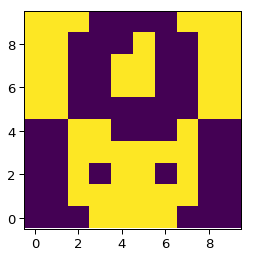

2.4093368


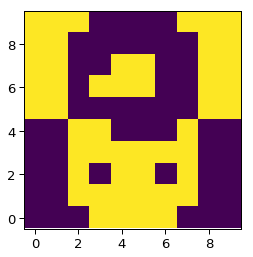

2.6787841


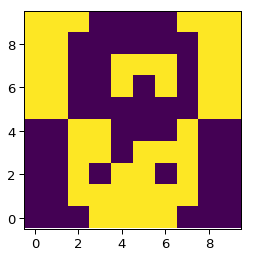

1.0723056


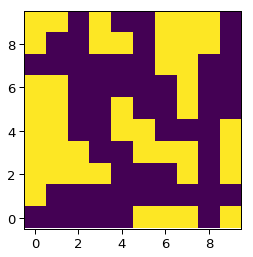

1.7880682


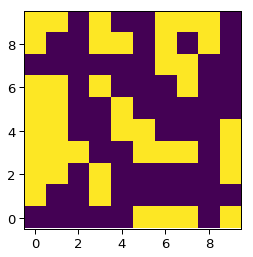

2.362506


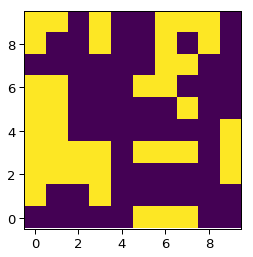

1.1866268


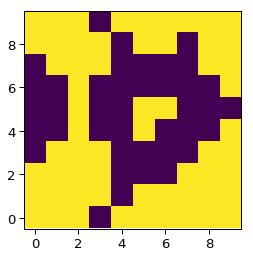

1.795607


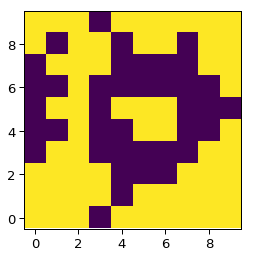

2.4842389


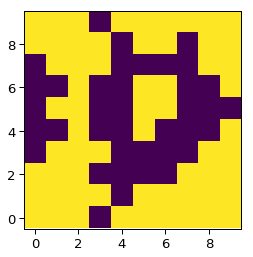

1.1974622


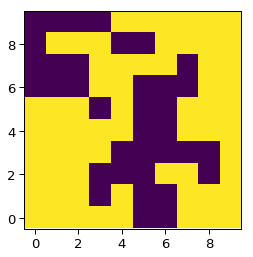

2.442715


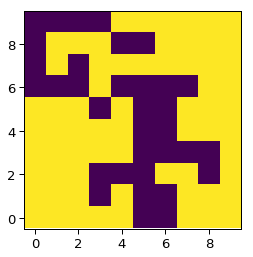

2.9713762


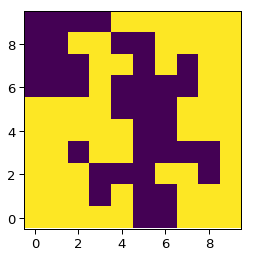

1.6149745


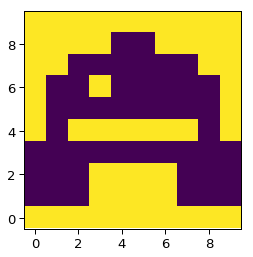

1.6352397


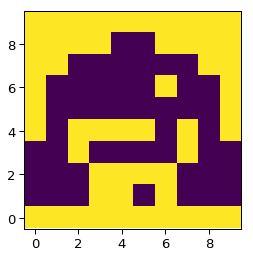

3.2530715


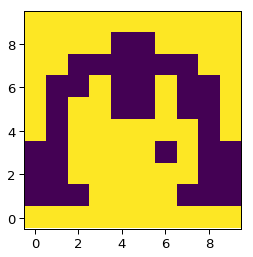

1.1113989


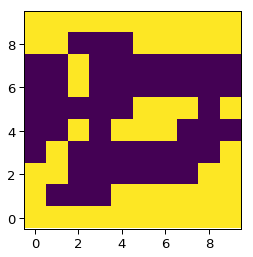

1.9344314


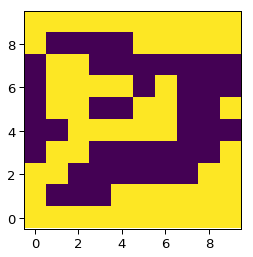

2.0346098


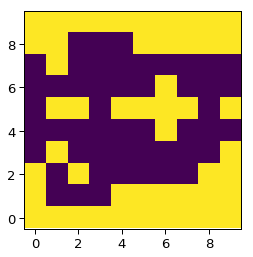

1.27396


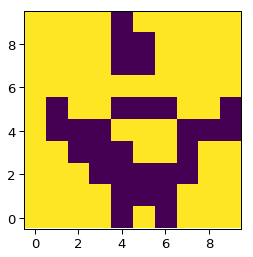

1.6472255


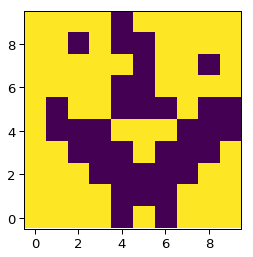

2.5904005


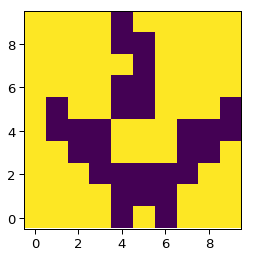

1.088827


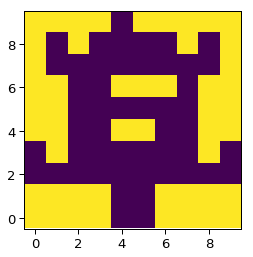

1.7769845


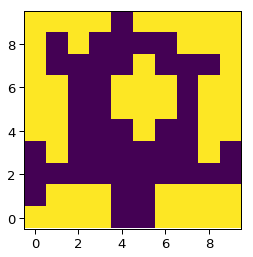

2.8291667


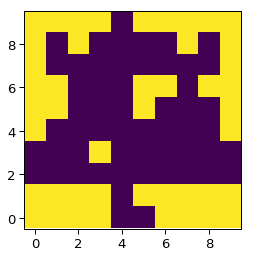

In [31]:
h=10
w=10
for i in range(len(x_mean)):
    #i=22
    plt.imshow(np.round(1/(1+np.exp(-x_mean[i, 1:101]))).reshape(10, 10), origin='below')
    print (x_mean[i, 0])
    #plt.colorbar()
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()
    
    #plt.imshow(voxels_design[i, :100].reshape(10, 10), origin='below')
    #plt.colorbar()
    #plt.show()
    
    #plt.imshow(x_mean[i].reshape([h, w]))
    #plt.show()

In [ ]:
np.savetxt("inverseAnimals_accuracy_from_INet_June20.csv", ac, delimiter=',')
np.savetxt("inverseAnimals_from_INet_June20.csv", np.round(1/(1+np.exp(-x_mean[:, 1:101]))), delimiter=",")
np.savetxt("inverseAnimals_from_INet_PRESSURE_June20.csv", x_mean[:, 0], delimiter=",")

In [64]:
listR2_voxels, listR2_binary, listR2_pressure = calculateAccuracy('test', 2, 3, 3, 0, 1, 1)


(3, 9220)
0.985140997830802 0.8037653560502599 0.9966666666666667 0.3894943120152661


In [89]:
print("change comb: ", comb)

change comb:  F


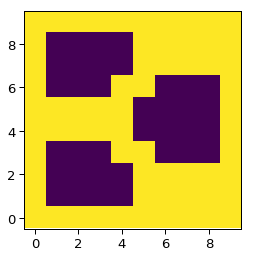

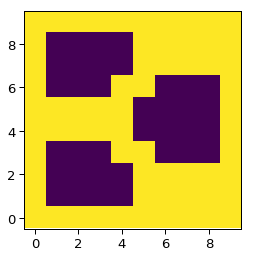

(3, 9220)
0.9916124367317426 0.9531725137355981 0.9899999999999999 0.9645627271499606


In [90]:
predictionMatrix = savePredictions('FE_case_1_HR_voxel.csv', comb, 2)


In [34]:
def savePredictions(filename, combinations, index):
    test_case1 = pd.read_csv(filename, delimiter=',', header=None)
    
    test_case1 = np.array (test_case1)
    p = np.ones((3, 1))
    #print(p.shape, test_case1.shape)
    p[0]=1
    p[1]=2
    p[2]=3
    #p = p.reshape ((3, 1))
    test_case1 = np.concatenate ((p, test_case1), axis=1)

    x_sample = test_case1[:, 0:101]
    y_sample = test_case1[:, 101:]
    

    #print (x_sample.shape, y_sample.shape)
    """Voxels accuracy"""
    
    
    feed_dict = {input_image: x_sample, y_true: y_sample}
    z_mu = sess.run(z,feed_dict=feed_dict)
    z_mu = np.round(z_mu)
    
    feed_dict = {input_image: x_sample, y_true: y_sample}
    x_mean = sess.run(decoder,feed_dict=feed_dict)
    #need to apply sigmoid to binaries 
    for jj in range(1, 101):
        x_mean[:, jj] =np.round(1/(1+np.exp(-x_mean[:, jj])))
    
    predictionMatrix = np.concatenate((x_mean, z_mu), axis=1 )
    plt.imshow((test_case1[index, 1:101].reshape([h, w])), origin='lower')
    plt.show()
    plt.imshow((predictionMatrix[index, 1:101].reshape([h, w])), origin='lower')
    plt.show()
    
    listR2_voxels, listR2_voxels_surface, listR2_binary, listR2_pressure = calculateAccuracy2('special', 2, 3, 3, 0, 1, 1)
    
    listR2_voxels = np.array(listR2_voxels)
    listR2_voxels = listR2_voxels.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_voxels), axis=1)
    
    listR2_voxels_surface = np.array(listR2_voxels_surface)
    listR2_voxels_surface = listR2_voxels_surface.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_voxels_surface), axis=1)

    
    listR2_binary = np.array(listR2_binary)
    listR2_binary = listR2_binary.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_binary), axis=1)

    
    listR2_pressure = np.array(listR2_pressure)
    listR2_pressure = listR2_pressure.reshape((len(z_mu), 1))
    
    predictionMatrix = np.concatenate((predictionMatrix, listR2_pressure), axis=1)
    

    
    np.savetxt("predictionsAndAccuracies-"+combinations+"-"+filename, predictionMatrix, delimiter=',')
    #np.savetxt("inverseAnimals_from_ML_f1000f500_Nov23.csv", np.round(1/(1+np.exp(-x_mean[:, 1:101]))), delimiter=",")
    #np.savetxt("inverseAnimals_from_ML_PRESSURE_f1000f500_Nov23.csv", x_mean[:, 0], delimiter=",")
    
    return predictionMatrix
#listR2_voxels, listR2_voxels_surface, listR2_binary, listR2_pressur

In [33]:
def calculateAccuracy(check):
    if check=='test':
        x_sample =X_test
        y_sample =y_test_all[:, :y_dim]
    if check=='valid':
        x_sample =X_valid
        y_sample =y_valid_all[:, :y_dim]
    if check=='train':
        x_sample =X_train
        y_sample =y_train_all[:, :y_dim]
    

    """Voxels accuracy"""
    
    
    feed_dict = {input_image: x_sample, y_true: y_sample}
    z_mu = sess.run(z,feed_dict=feed_dict)
    z_mu = np.round(z_mu)
    
    ave_R2 = 0 
    mse = 0 
    listR2 = []
    listMSE = []

    for jj in range(y_dim):
        
        r2s = accuracy_score(y_sample[:, jj], z_mu[:, jj])
        ave_R2 = ave_R2+r2s
        temp  = np.sum((y_sample[:, jj]-z_mu[:, jj])**2)
        mse = mse+temp
        listMSE.append(temp)
        listR2.append(r2s)
    #print(r2s, temp)

    
    ac_voxel = ave_R2/y_dim  
    #print ("Average accuracy score for all element:", ave_R2/y_dim, mse/y_dim/len(y_sample))

    ave_wscore = 0 

    for i in range (len(y_sample)):
        err = weighted_score (y_sample[i], z_mu[i])
    #print (i, err)
        ave_wscore += err

    ac_wvoxel = ave_wscore/len(y_sample)
#print ("Weighted average:", ave_wscore/len(y_sample))



    """Binary accuracy score and R2 on pressure"""
    #x_sample =X_train
    #y_sample =y_train_all[:, :y_dim]

    feed_dict = {input_image: x_sample, y_true: y_sample}
    x_mean = sess.run(decoder,feed_dict=feed_dict)
    
    ave_R2 = 0 
    mse = 0 
    listR2 = []
    listMSE = []

    for jj in range(1, 101):
        
        r2s = accuracy_score(x_sample[:, jj], np.round(1/(1+np.exp(-x_mean[:, jj]))))
        ave_R2 = ave_R2+r2s
        temp  = np.sum((x_sample[:, jj]-np.round(1/(1+np.exp(-x_mean[:, jj]))))**2)
        mse = mse+temp
        listMSE.append(temp)
        listR2.append(r2s)
    #print(r2s, temp)
        
        
#print ("Accuracy score on binary configurations:", ave_R2/100, mse/100/len(y_sample))
    ac_binary = ave_R2/100

    ave_R2 = 0 
    mse = 0 
    listR2 = []
    listMSE = []
    for jj in range(0, 1):
        r2s = r2_score(x_sample[:, jj], x_mean[:, jj])
        ave_R2 = ave_R2+r2s
        temp  = np.sum((x_sample[:, jj]-x_mean[:, jj])**2)
        mse = mse+temp
        listMSE.append(temp)
        listR2.append(r2s)
    #print(r2s, temp)

    ac_press = ave_R2
    
    return [ac_voxel, ac_wvoxel, ac_binary, ac_press]
#print ("R2 score :", ave_R2, mse/len(y_sample))

In [34]:
listdata=['test']
for check in listdata:
    print(calculateAccuracy(check))

[0.9892276271390664, 0.9347503553012836, 0.9919822222222221, 0.9121585278634271]


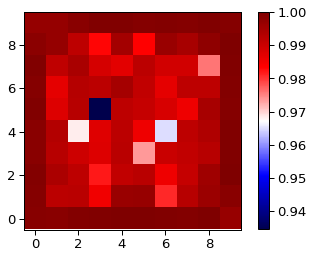

In [110]:
plt.imshow((np.array(listR2_binary).reshape([h, w])), origin='lower', cmap='seismic')
plt.colorbar()

### INVERSE DESIGN 

In [77]:
#dataformat for inverse designs input voxels 
#truth binary1, voxels1 w pressure 1
#truth binary1, voxels1 w pressure 2
#truth binary1, voxels1 w pressure 3
#truth binary2, voxels w pressure 1
#....
#....

allDesigns=True
if allDesigns:
    #voxels_design = genfromtxt('inverseAll.csv', delimiter=',')
    voxels_design = genfromtxt('inverse_scarsNew.csv', delimiter=',')


    znew = voxels_design[:, 100:]
#znew = znew.reshape((1,YDIM))
    #znew.shape
else:
    voxels_design = genfromtxt('dog11_HR_voxel.csv', delimiter=',')
    znew = voxels_design[2, 100:]
    znew = znew.reshape((1, YDIM))
    

In [4]:
YDIM

9220

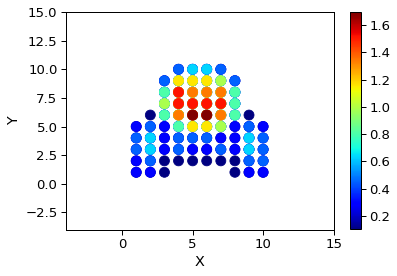

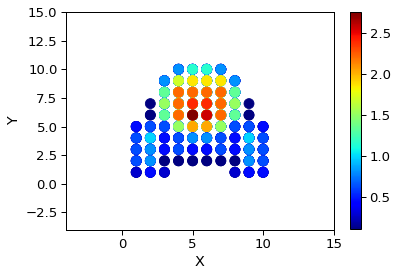

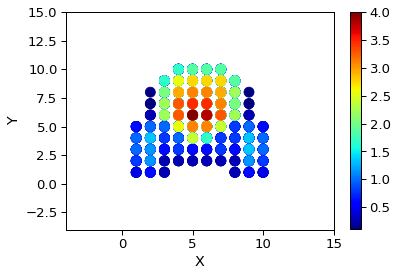

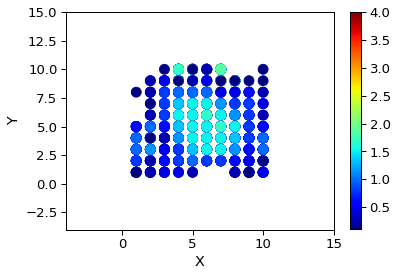

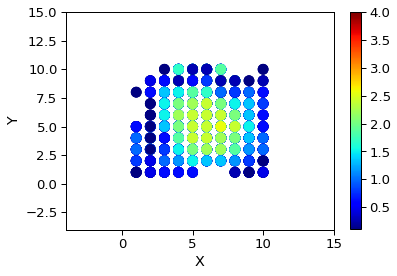

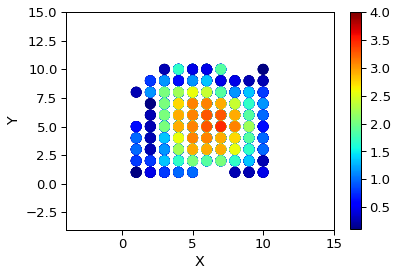

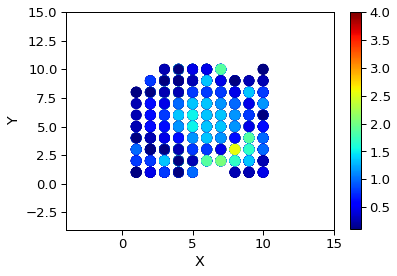

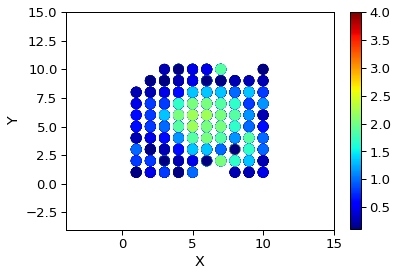

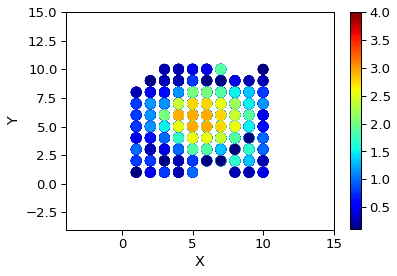

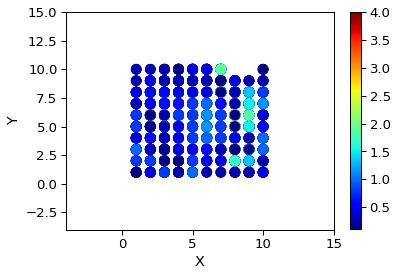

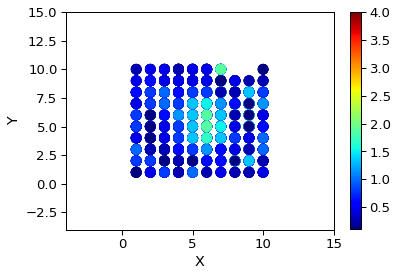

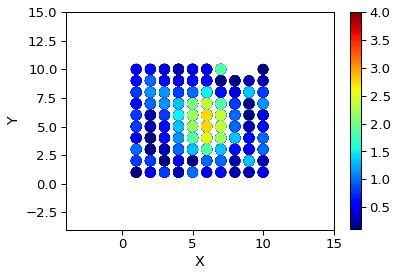

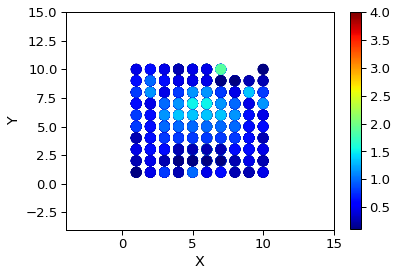

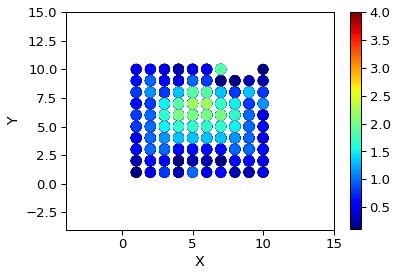

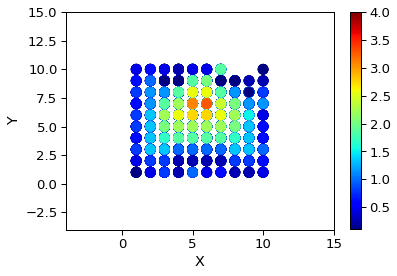

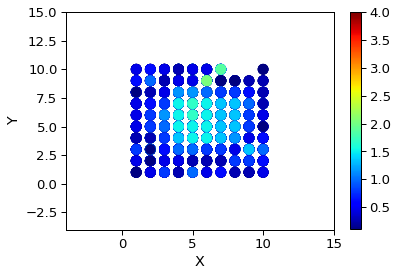

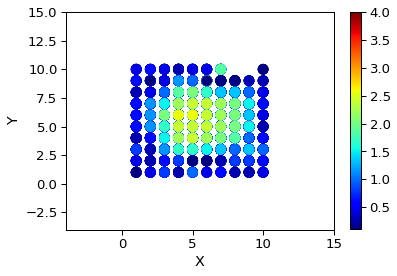

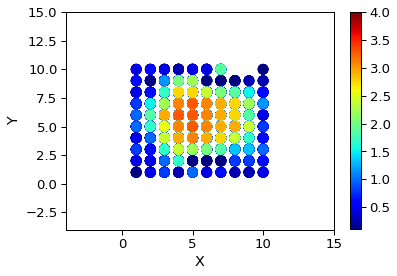

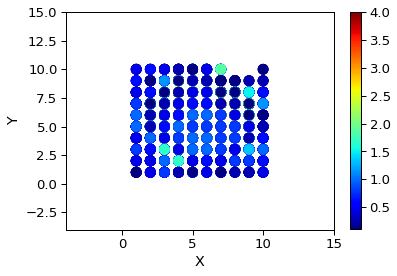

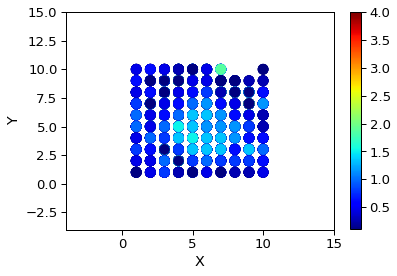

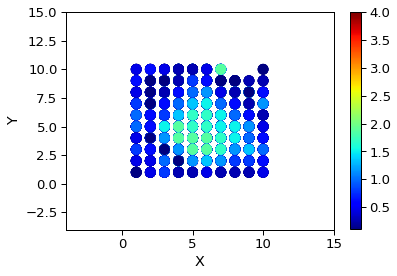

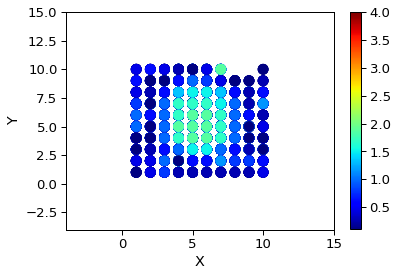

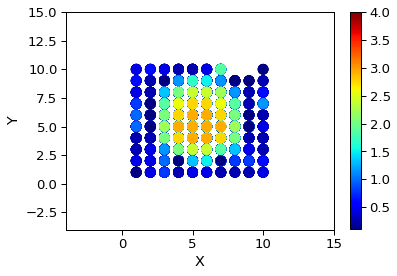

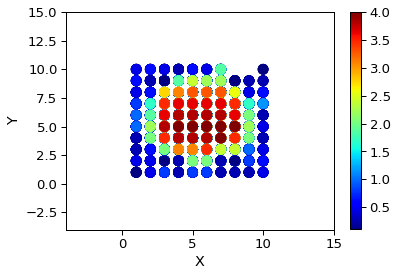

In [60]:
#visualize designs 
point = []
k=0
for j in range (len(znew)):
    for i in range(0, YDIM):
        if znew[j][i+k]==1:
            point.append(xyz[i])
    surface = np.array(point)
    #X = surface[:, 0]
    #Y = surface[:, 1]
    #Z = surface[:, 2]
    scatter2d(surface, 'jet')

## for scars inverse designs 

In [157]:
allDesigns=True
if allDesigns:
    voxels_design = genfromtxt('scarAll_blender.csv', delimiter=',')

    znew = voxels_design
#znew = znew.reshape((1,YDIM))
    #znew.shape
else:
    voxels_design = genfromtxt('.csv', delimiter=',')
    znew = voxels_design[2, 100:]
    znew = znew.reshape((1, YDIM))

In [158]:
truth = genfromtxt('scar_designs_new.csv', delimiter=',')

In [150]:
znew.shape

(4, 9220)

In [159]:
z_input = tf.placeholder(tf.float32, shape=[None, latent_dim+y_dim])

decoder2 = tf.matmul(z_input, weightsx['decoder_h1']) + biasesx['decoder_b1']
decoder2 = tf.nn.relu(decoder2)
decoder2 = tf.matmul(decoder2, weightsx['decoder_h2']) + biasesx['decoder_b2']
decoder2 = tf.nn.relu(decoder2)
decoder2 = tf.matmul(decoder2, weightsx['decoder_out']) + biasesx['decoder_out']
#decoder2 = tf.nn.sigmoid(decoder2)
#decoder2 = tf.round(decoder2) #REMEMBER already use ROUND function 

x_mean = sess.run(decoder2, feed_dict = {z_input:znew})

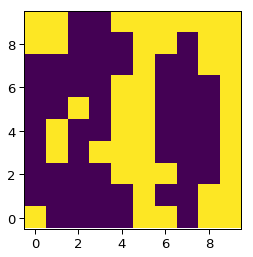

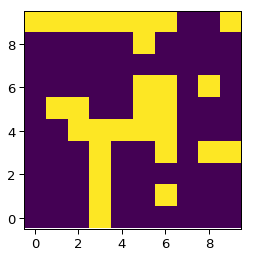

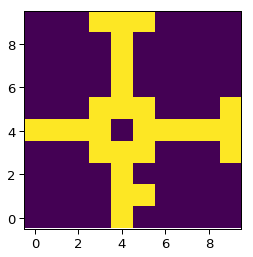

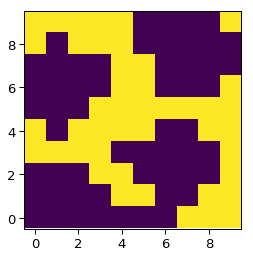

In [160]:
h=10
w=10
for i in range(len(x_mean)):
    plt.imshow(np.round(1/(1+np.exp(-x_mean[i, 1:101]))).reshape(10, 10), origin='below')
    #plt.colorbar()
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()
    
    #plt.imshow(voxels_design[i, :100].reshape(10, 10), origin='below')
    #plt.colorbar()
    
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()

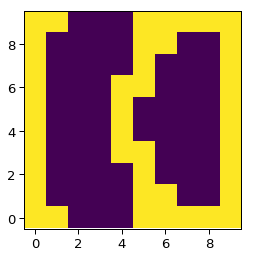

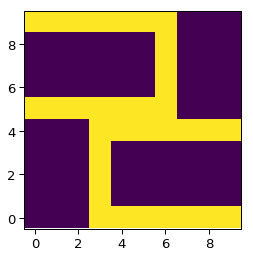

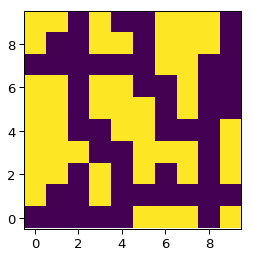

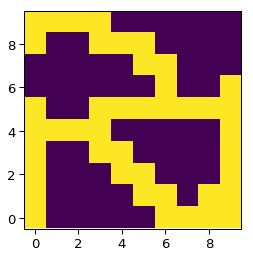

In [114]:
h=10
w=10
for i in range(len(truth)):
    plt.imshow(truth[i].reshape(10, 10), origin='below')
    #plt.colorbar()
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()
    
    #plt.imshow(voxels_design[i, :100].reshape(10, 10), origin='below')
    #plt.colorbar()
    
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()

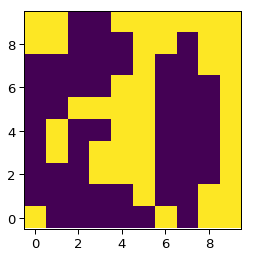

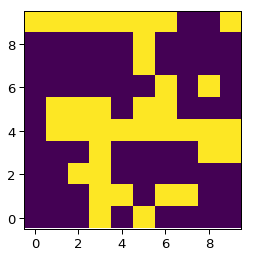

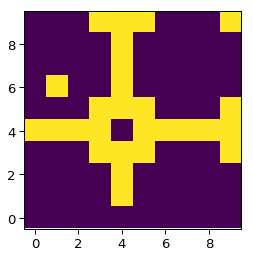

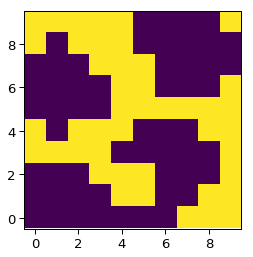

In [127]:
h=10
w=10
for i in range(len(x_mean)):
    plt.imshow(np.round(1/(1+np.exp(-x_mean[i, 1:101]))).reshape(10, 10), origin='below')
    #plt.colorbar()
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()
    
    #plt.imshow(voxels_design[i, :100].reshape(10, 10), origin='below')
    #plt.colorbar()
    
    #plt.imshow(x_mean[i].reshape([h, w]))
    plt.show()

In [161]:
for i in range (len(truth)):
    print(accuracy_score(truth[i], np.round(1/(1+np.exp(-x_mean[i, 1:101])))))
    #print(accuracy_score(truth[i], np.round(1/(1+np.exp(-x_mean[i, 1:101])))))

0.77
0.77
0.48
0.75


In [122]:
accuracy_score(truth[i], np.round(1/(1+np.exp(-x_mean[i, 1:101]))))

0.75

In [ ]:
x_mean.shape

In [41]:
np.savetxt("inverseScarsNEW_from_ML_f1000f500.csv", np.round(1/(1+np.exp(-x_mean[:, 1:101]))), delimiter=",")
np.savetxt("inverseScarsNEW_from_ML_PRESSURE_f1000f500.csv", x_mean[:, 0], delimiter=",")

In [64]:
x_mean[:, 0]

array([3.266179 , 3.0784857, 2.6861923, 2.591361 ], dtype=float32)

In [50]:
znew.shape

(4, 9120)

In [73]:
x_mean[0]

array([  2.4760978 , -10.910099  , -13.055481  ,   6.684251  ,
         4.9319587 ,   6.129295  ,   4.7019477 ,  10.154163  ,
         5.76051   , -14.20537   ,  -2.5876265 , -29.524912  ,
        -1.3984668 ,   9.333861  ,   3.5009468 ,   4.3377542 ,
         5.4654574 ,   2.2476947 ,   6.168911  ,   2.5699847 ,
       -29.613396  , -29.669239  , -11.733353  ,   9.479794  ,
         8.585847  ,   5.2028575 ,   3.7478638 ,   5.0194616 ,
        11.838058  ,  -6.7169423 , -22.155792  , -32.650486  ,
        -4.205023  ,   7.932724  ,   7.3383684 ,   7.104083  ,
         6.3437877 ,   6.1039352 ,   7.024172  ,   2.2943726 ,
       -18.33981   ,  -8.979592  ,   7.164919  ,   7.209422  ,
         0.07152042,  -9.762073  ,  -8.547603  ,  -2.0512369 ,
         4.5624986 ,   4.2344007 , -15.261161  ,   7.800901  ,
         7.3658733 ,   0.33582848, -11.356086  , -16.663437  ,
       -10.499478  ,  -4.5935254 ,   2.446524  ,   1.6279212 ,
         5.483678  ,   5.964802  ,   4.5434303 ,  -2.27

In [67]:
x_mean.shape

(1, 101)

In [48]:
np.savetxt("binary_design_for_L_ep50_batch100.csv", x_mean, delimiter=",")